# Solving XOR Problem

XOR Problem is a non-linearly seperable problem as it is impossible to draw a single hyperplane or straight line to seperate the inputs corresponding to True or False. This is demostrated by the graph below. However, as seen by the second diagram, we can use a non-linear decision boundary such as a circle to seperate the XOR classes.

In [1]:
import os

save_base_path = "../sources" 

print(os.path.exists(save_base_path))

True


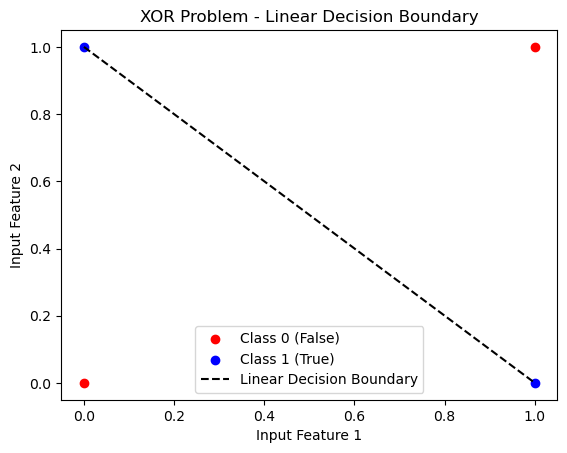

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# XOR input and output
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0])

# Plotting XOR data points
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', label='Class 0 (False)')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class 1 (True)')

# Plotting linear decision boundary 
plt.plot([0, 1], [1, 0], color='black', linestyle='--', label='Linear Decision Boundary')

plt.title('XOR Problem - Linear Decision Boundary')
plt.xlabel('Input Feature 1')
plt.ylabel('Input Feature 2')
plt.legend()

plt.savefig(os.path.join(save_base_path, 'XOR_Problem-Linear_Decision_Boundary.png'))

plt.show()

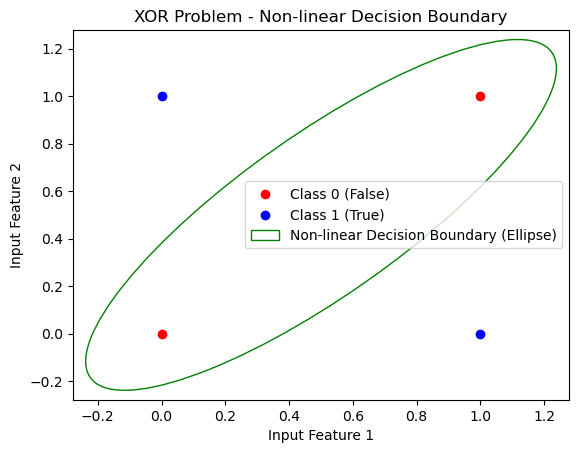

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# XOR input and output
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0])

# Plotting XOR data points
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', label='Class 0 (False)')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class 1 (True)')

# Plotting non-linear decision boundary (ellipse)
ellipse = plt.matplotlib.patches.Ellipse((0.5, 0.5), width=2, height=0.6, angle=45, color='green', fill=False, label='Non-linear Decision Boundary (Ellipse)')
plt.gca().add_patch(ellipse)


plt.title('XOR Problem - Non-linear Decision Boundary')
plt.xlabel('Input Feature 1')
plt.ylabel('Input Feature 2')
plt.legend()

plt.savefig(os.path.join(save_base_path, 'XOR_Problem-Non_Linear_Decision_Boundary.png'))

plt.show()

# Solution 1: Multi-Layer Perceptron

By using a multi-layer perceptron with one hidden layer and neurons with a non-linear transfer function such as sigmoid can approximate any continuous function (i.e it is a universal approximator). This is shown by the example below.

Accuracy: 100.00%


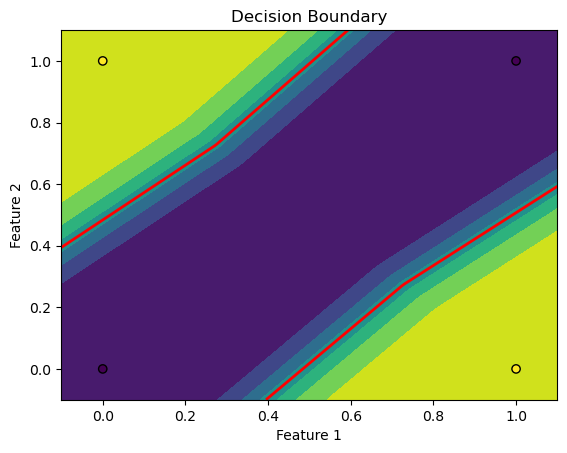

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Create XOR data
X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
y = torch.tensor([0, 1, 1, 0], dtype=torch.float32).view(-1, 1)

# Define model, loss, and optimizer
input_size = 2
hidden_size = 10
output_size = 1
model = MLP(input_size, hidden_size, output_size)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Train the model
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

# Visualize the decision boundary
def visualize_decision_boundary(model):
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    # Create a grid of points
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

    # Use the model to predict labels for each point in the grid
    with torch.no_grad():
        Z = model(grid_tensor).detach().numpy()

    # Plot the decision boundary
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z)
    plt.contour(xx, yy, Z, levels=[0.5], linewidths=2, colors='red')
    plt.scatter(X[:, 0], X[:, 1], c=y.numpy().squeeze(), cmap='viridis', edgecolors='k', marker='o')
    plt.title('Decision Boundary')

# Calculate accuracy
def get_accuracy():
    with torch.no_grad():
        predicted_labels = (model(X) > 0.5).float()
        accuracy = torch.sum(predicted_labels == y) / len(y)
        print(f'Accuracy: {accuracy.item() * 100:.2f}%')

visualize_decision_boundary(model)
get_accuracy()

plt.savefig(os.path.join(save_base_path, 'XOR_Solution-MLP.png'))

plt.show()

# Solution 2: RBF Neuron

RBF neurons use a non-linear activation function (Gaussian radial basis function) that allows them to model complex, non-linear relationships between inputs and outputs. They also perform kernel tricks using their activation functions which allows it to represent non-linear decision boundaries. This is demostrated by the code below whereby the decision boundary is visualized by a contour map.

This method seeks to optimize the positions of the centers of each RBF neuron (which can be thought of as a circle of radius gamma) and the weights.

It is recommended to set the hidden layer to a sufficiently high number so that the accuracy of the trained model converges to a decision boundary that can solve the XOR problem.

Accuracy: 100.00%


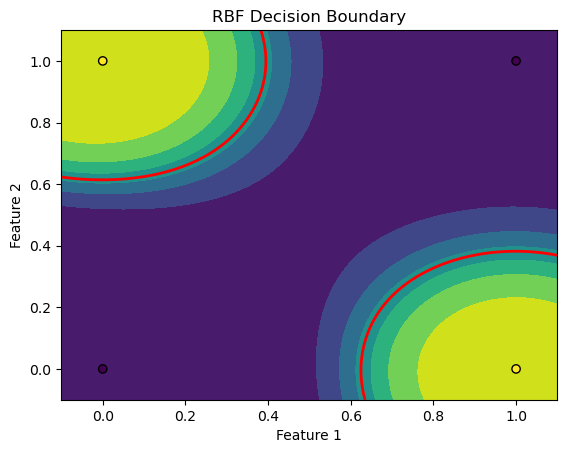

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

# Radial Basis Function (RBF) activation
class RBFActivation(nn.Module):
    def __init__(self, centers, gamma):
        super(RBFActivation, self).__init__()
        self.centers = nn.Parameter(centers)
        self.gamma = gamma

    def forward(self, x):
        # Compute radial basis function values
        rbf = torch.exp(-self.gamma * torch.sum((x.unsqueeze(1) - self.centers) ** 2, dim=2))
        return rbf

# RBF Neural Network Model
class RBFNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, gamma):
        super(RBFNetwork, self).__init__()
        self.rbf_activation = RBFActivation(nn.Parameter(torch.randn(hidden_size, input_size)), gamma)
        self.linear = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        rbf_output = self.rbf_activation(x)
        linear_output = self.linear(rbf_output)
        return self.sigmoid(linear_output)

# Create XOR data
X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
y = torch.tensor([0, 1, 1, 0], dtype=torch.float32).view(-1, 1)

# Define RBF Neural Network
input_size = 2
hidden_size = 10  # Higher numbers give more consistency in accuracy
output_size = 1
gamma = 5.0  # Adjust the value of gamma
rbf_model = RBFNetwork(input_size, hidden_size, output_size, gamma)
criterion = nn.BCELoss()
optimizer = optim.SGD(rbf_model.parameters(), lr=0.1)

# Train RBF Neural Network
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = rbf_model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

# Visualize the decision boundary
def visualize_decision_boundary(model):
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    # Create a grid of points
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

    # Use the model to predict labels for each point in the grid
    with torch.no_grad():
        Z = model(grid_tensor).detach().numpy()
        Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z)
    plt.contour(xx, yy, Z, levels=[0.5], linewidths=2, colors='red')
    plt.title('RBF Decision Boundary')
    plt.scatter(X[:, 0], X[:, 1], c=y.numpy().squeeze(), cmap='viridis', edgecolors='k', marker='o')

# Calculate accuracy
def get_accuracy():
    with torch.no_grad():
        predicted_labels = (rbf_model(X) > 0.5).float()
        accuracy = torch.sum(predicted_labels == y) / len(y)
        print(f'Accuracy: {accuracy.item() * 100:.2f}%')

visualize_decision_boundary(rbf_model)
get_accuracy()

plt.savefig(os.path.join(save_base_path, 'XOR_Solution-RBF.png'))

plt.show()

# Bonus Graph: LAF Tanh from (-1, 1)

[[-1.    -0.75  -0.5   -0.25   0.     0.25   0.5    0.75   1.   ]
 [-0.5   -0.375 -0.25  -0.125  0.     0.125  0.25   0.375  0.5  ]]


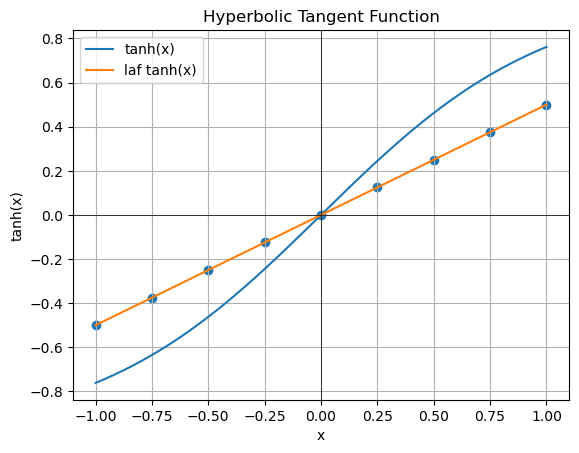

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math

np.seterr(divide='ignore')

def laf_tanh(x):
    # sgn * ((1.0 / (1 << intPart(absolute(val)))) * ((fracPart(absolute(val)) / 2.0) - 1.0) + 1)
    return np.sign(x) * ( (1.0 / (1 << np.abs(x).astype(int))) * ((np.mod((np.abs(x)), 1) / 2.0) - 1.0) + 1 )
    
# Generate x values from -1 to 1 since that is the valid region for laf_tanh
x_values = np.linspace(-1, 1, 1000)

# Calculate tanh values for each x
tanh_values = np.tanh(x_values)
laf_tanh_values = laf_tanh(x_values)

# Plot the tanh function
plt.plot(x_values, tanh_values, label='tanh(x)')
plt.plot(x_values, laf_tanh_values, label='laf tanh(x)')
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.title('Hyperbolic Tangent Function')
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.legend()

test_val = np.linspace(-1, 1, 9)
pred_val = laf_tanh(test_val)

print(np.vstack((test_val, pred_val)))
plt.scatter(test_val, pred_val)

plt.show()

# Bonus Graph: LAF Sigmoid 

[[-1.    -0.75  -0.5   -0.25   0.     0.25   0.5    0.75   1.   ]
 [ 0.5    0.625  0.75   0.875  1.     0.875  0.75   0.625  0.5  ]]


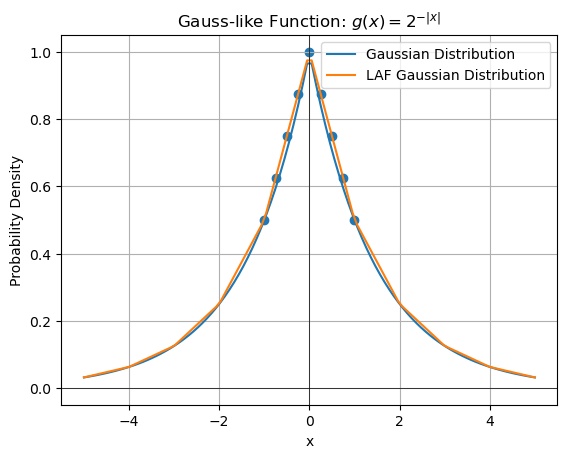

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def laf_gaussian(x):
    # (1.0 / (1 << intPart(absolute(val)))) * (1 - fracPart(absolute(val)) / 2.0)
    return (1.0 / (1 << np.abs(x).astype(int))) * (1 - np.mod(np.abs(x), 1) / 2.0)

def gaussian(x):
    return 2 ** -np.abs(x)

# Generate x values from -5 to 5
x_values = np.linspace(-5, 5, 100)
laf_gauss_values = laf_gaussian(x_values)

# Calculate the PDF values for each x
gauss_values = gaussian(x_values)

# Plot the Gaussian distribution
plt.plot(x_values, gauss_values, label='Gaussian Distribution')
plt.plot(x_values, laf_gauss_values, label='LAF Gaussian Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Gauss-like Function: $g(x)=2^{-|x|}$')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()

test_val = np.linspace(-1, 1, 9)
pred_val = laf_gaussian(test_val)
print(np.vstack((test_val, pred_val)))
plt.scatter(test_val, pred_val)

plt.show()

# LAF Benchmarks - Deviation from True value

## Plots 
Plots of the true vs LAF value with 1000 points.

## Metrics (From LAF - Actual)
1) Max error $\epsilon_{max}= true - estimated value$
2) Mean of error
3) Std deviation of error

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import math

# LAF Functions

def laf_exp(x):
    return (1 << x.astype(int)) * (1 + np.mod(x, 1))

def leftmost_one(n):
    """ Returns position of left most 1 in binary, equivalent to int(log(x)) """
    mask = n == 0
    
    # Bit smearing technique
    n |= (n >> 1)
    n |= (n >> 2)
    n |= (n >> 4)
    n |= (n >> 8)
    n |= (n >> 16)
    n |= (n >> 32)

    # Leftmost bit is now alone in its column
    # Extract position of leftmost 1 value
    positions = np.zeros_like(n, dtype=int)

    while np.any(n & 1):
        positions += n & 1
        n >>= 1

    positions -= 1
    positions = np.where(mask, -1, positions)
    
    return positions
    
def laf_log(x):
    leftmost_bit = leftmost_one(x.astype(int))
    return leftmost_bit + (x / (1 << leftmost_bit)) - 1

def laf_tanh(x):
    # sgn * ((1.0 / (1 << intPart(absolute(val)))) * ((fracPart(absolute(val)) / 2.0) - 1.0) + 1)
    return np.sign(x) * ( (1.0 / (1 << np.abs(x).astype(int))) * ((np.mod((np.abs(x)), 1) / 2.0) - 1.0) + 1 )
    
def laf_gaussian(x):
    # (1.0 / (1 << intPart(absolute(val)))) * (1 - fracPart(absolute(val)) / 2.0)
    return (1.0 / (1 << np.abs(x).astype(int))) * (1 - np.mod(np.abs(x), 1) / 2.0)

""" Note all operations here are precision sensitive - The assumption is single precision for floats and ints (32 bits) """
def laf_mul(x, y, n=14):
    return np.sign(x) * np.sign(y) * laf_exp(laf_log((1 << n) * np.abs(x)) + laf_log((1 << n) * np.abs(y))) / (1 << (2 * n))
    # return np.sign(x) * np.sign(y) * np.exp(np.log((1 << n) * np.abs(x)) + np.log((1 << n) * np.abs(y))) / (1 << (2 * n))

def laf_sqr(x, n=14):
    return laf_exp(2 * laf_log((1 << n) * np.abs(x))) / (1 << (2*n))

def laf_sqrt(x, n=14):
    # Binary exponentiation was not use to get power of non integers like it was done in C
    # Might lead to some inaccuracies
    return laf_exp(0.5 * laf_log((1 << n) * x)) / (2 ** (n/2))

# Actual Functions

def exp(x):
    return np.exp2(x)
    
def log(x):
    return np.log2(x)

def tanh(x):
    return np.tanh(x_values)

def gaussian(x):
    return 2 ** -np.abs(x)

def mul(x, y):
    return x * y

def sqr(x):
    return x ** 2

def sqrt(x):
    return np.sqrt(x)

def gaussian(x):
    return 2 ** -np.abs(x)

# Error Functions

def mean_absolute_error(actual, predicted):
    return np.mean(np.abs(actual - predicted))

def mean_squared_error(actual, predicted):
    return np.mean((actual - predicted) ** 2)

def root_mean_squared_error(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

def describe_error(function_name, x_min, x_max, actual, predicted):
    errors = actual - predicted
    percentage_errors = (actual - predicted) / actual

    mean_error = np.mean(errors)
    std_error = np.std(errors)
    var_error = np.var(errors)

    max_error = np.max(errors)
    min_error = np.min(errors)
    max_percentage_error = np.where(np.abs(max_error) > np.abs(min_error), percentage_errors[np.argmax(errors)], percentage_errors[np.argmin(errors)])

    result = {'Function': function_name,
              'X Lower': x_min,
              'X Upper': x_max,
              'Mean Error': mean_error,
              'Variance of Error': var_error,
              'Maximum Error': max_percentage_error}
    
    return result

def where_max_error(actual, predicted):
    errors = actual - predicted
    max_error = np.max(errors)
    min_error = np.min(errors)
    error_idx = np.where(np.abs(max_error) > np.abs(min_error), np.argmax(errors), np.argmin(errors))
    return error_idx

In [9]:
import pandas as pd

error_data = []  # for creating dataframe of all errors

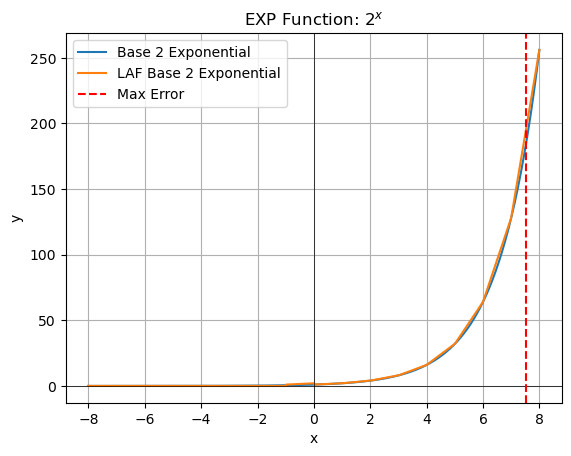

In [10]:
# EXP: unspecified

# Generate x values
x_min = -8
x_max = 8
x_values = np.linspace(x_min, x_max, 1000, dtype=np.float32)
exp_values = exp(x_values)
laf_exp_values = laf_exp(x_values)

# Plot the Gaussian distribution
plt.plot(x_values, exp_values, label='Base 2 Exponential')
plt.plot(x_values, laf_exp_values, label='LAF Base 2 Exponential')
plt.xlabel('x')
plt.ylabel('y')
plt.title('EXP Function: $2^{x}$')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()

max_error_idx = where_max_error(exp_values, laf_exp_values)
plt.axvline(x=x_values[max_error_idx], color='red', linestyle='--', label='Max Error')

plt.legend()

plt.savefig(os.path.join(save_base_path, 'LAF-EXP.png'))

plt.show()

# Describe functions
error_data.append(describe_error("EXP", x_min, x_max, exp_values, laf_exp_values))

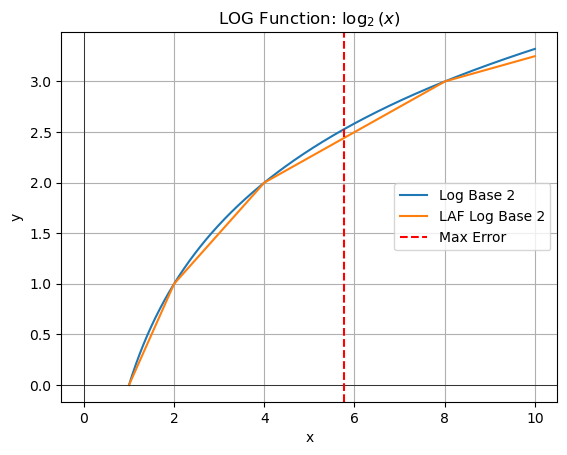

In [11]:
# LOG: (1, inf)

# Generate x values
x_min = 1.000001
x_max = 10
x_values = np.linspace(x_min, x_max, 1000, dtype=np.float32)
log_values = log(x_values)
laf_log_values = laf_log(x_values)

# Plot the Gaussian distribution
plt.plot(x_values, log_values, label='Log Base 2')
plt.plot(x_values, laf_log_values, label='LAF Log Base 2')
plt.xlabel('x')
plt.ylabel('y')
plt.title('LOG Function: $\log_{2}(x)$')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

max_error_idx = where_max_error(log_values, laf_log_values)
plt.axvline(x=x_values[max_error_idx], color='red', linestyle='--', label='Max Error')

plt.legend()
plt.savefig(os.path.join(save_base_path, 'LAF-LOG.png'))
plt.show()

# Describe functions
error_data.append(describe_error("LOG", x_min, x_max, log_values, laf_log_values))

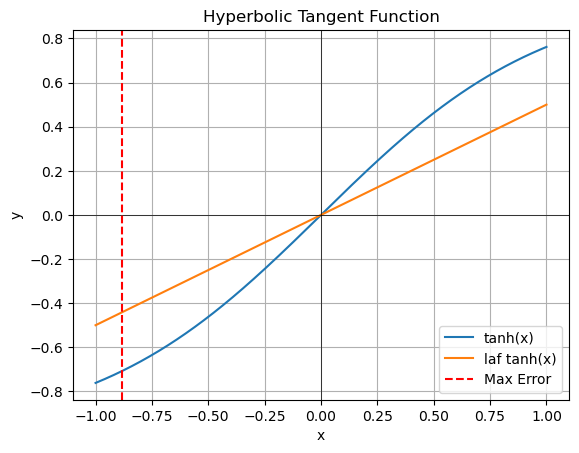

In [12]:
# AF / tanh: (-1, 1)

# Generate x values
x_min = -1
x_max = 1
x_values = np.linspace(x_min, x_max, 1000, dtype=np.float32)
tanh_values = tanh(x_values)
laf_tanh_values = laf_tanh(x_values)

# Plot the Gaussian distribution
plt.plot(x_values, tanh_values, label='tanh(x)')
plt.plot(x_values, laf_tanh_values, label='laf tanh(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Hyperbolic Tangent Function')
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)

max_error_idx = where_max_error(tanh_values, laf_tanh_values)
plt.axvline(x=x_values[max_error_idx], color='red', linestyle='--', label='Max Error')

plt.legend()
plt.savefig(os.path.join(save_base_path, 'LAF-AF.png'))
plt.show()

# Describe functions
error_data.append(describe_error("AF", x_min, x_max, tanh_values, laf_tanh_values))

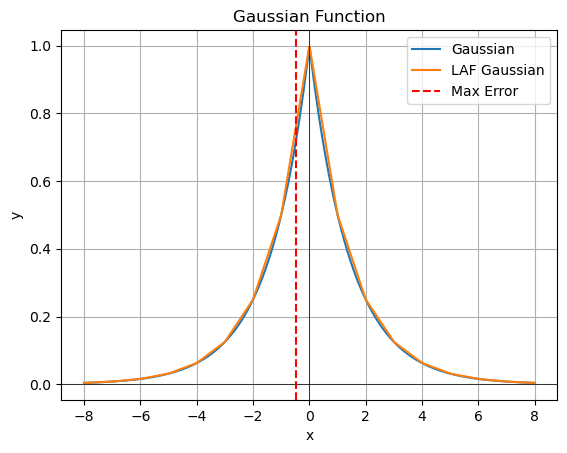

In [13]:
# AFR / Gaussian: unspecified - Test on (-8, 8)

# Generate x values
x_min = -8
x_max = 8
x_values = np.linspace(x_min, x_max, 1000, dtype=np.float32)
values = gaussian(x_values)
laf_values = laf_gaussian(x_values)

# Plot the Gaussian distribution
plt.plot(x_values, values, label='Gaussian')
plt.plot(x_values, laf_values, label='LAF Gaussian')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gaussian Function')
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)

max_error_idx = where_max_error(values, laf_values)
plt.axvline(x=x_values[max_error_idx], color='red', linestyle='--', label='Max Error')

plt.legend()
plt.savefig(os.path.join(save_base_path, 'LAF-AFR.png'))
plt.show()

# Describe functions
error_data.append(describe_error("AFR", x_min, x_max, values, laf_values))

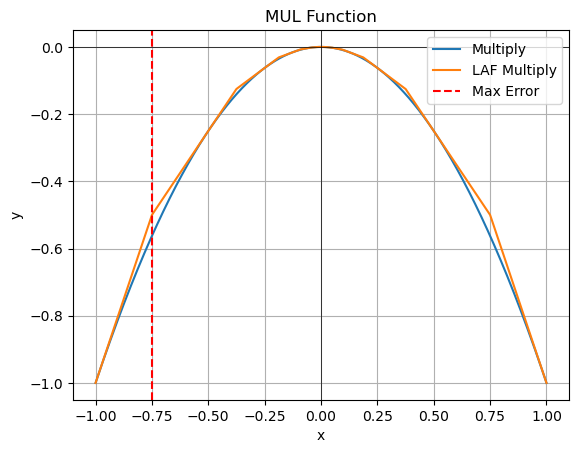

In [14]:
# MUL: (-1, 1)

# Generate x values
x_min = -1
x_max = 1
x_values = np.linspace(x_min, x_max, 1000, dtype=np.float32)
y_values = np.linspace(x_max, x_min, 1000, dtype=np.float32)
values = mul(x_values, y_values)
laf_values = laf_mul(x_values, y_values)

# Plot the Gaussian distribution
plt.plot(x_values, values, label='Multiply')
plt.plot(x_values, laf_values, label='LAF Multiply')
plt.xlabel('x')
plt.ylabel('y')
plt.title('MUL Function')
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)

max_error_idx = where_max_error(values, laf_values)
plt.axvline(x=x_values[max_error_idx], color='red', linestyle='--', label='Max Error')

plt.legend()
plt.savefig(os.path.join(save_base_path, 'LAF-MUL.png'))
plt.show()

# Describe functions
error_data.append(describe_error("MUL", x_min, x_max, values, laf_values))

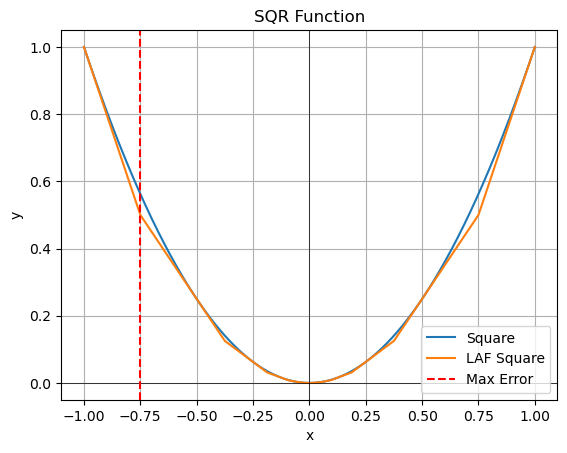

In [15]:
# SQR: (-1, 1)

# Generate x values
x_min = -1
x_max = 1
x_values = np.linspace(x_min, x_max, 1000, dtype=np.float32)
values = sqr(x_values)
laf_values = laf_sqr(x_values)

# Plot the Gaussian distribution
plt.plot(x_values, values, label='Square')
plt.plot(x_values, laf_values, label='LAF Square')
plt.xlabel('x')
plt.ylabel('y')
plt.title('SQR Function')
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)

max_error_idx = where_max_error(values, laf_values)
plt.axvline(x=x_values[max_error_idx], color='red', linestyle='--', label='Max Error')

plt.legend()
plt.savefig(os.path.join(save_base_path, 'LAF-SQR.png'))
plt.show()

# Describe functions
error_data.append(describe_error("SQR", x_min, x_max, values, laf_values))

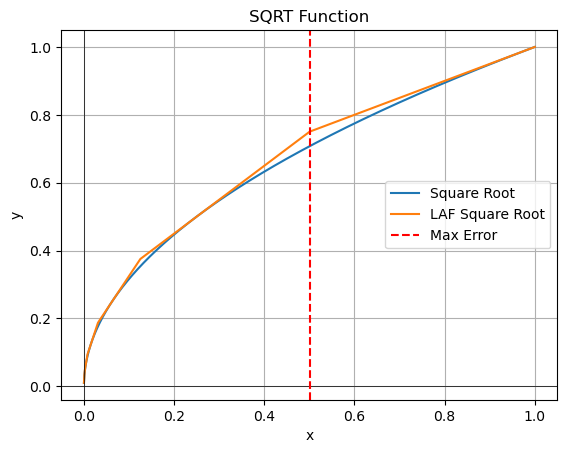

In [16]:
# SQRT: (0, 1)

# Generate x values
x_min = 0.0001
x_max = 1
x_values = np.linspace(x_min, x_max, 1000, dtype=np.float32)
values = sqrt(x_values)
laf_values = laf_sqrt(x_values)

# Plot the Gaussian distribution
plt.plot(x_values, values, label='Square Root')
plt.plot(x_values, laf_values, label='LAF Square Root')
plt.xlabel('x')
plt.ylabel('y')
plt.title('SQRT Function')
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)

max_error_idx = where_max_error(values, laf_values)
plt.axvline(x=x_values[max_error_idx], color='red', linestyle='--', label='Max Error')

plt.legend()
plt.savefig(os.path.join(save_base_path, 'LAF-SQRT.png'))
plt.show()

# Describe functions
error_data.append(describe_error("SQRT", x_min, x_max, values, laf_values))

In [17]:
error_df = pd.DataFrame(error_data)
display(error_df)

,Function,X Lower,X Upper,Mean Error,Variance of Error,Maximum Error
0,EXP,-8.000000,8,-0.915841,4.590556,-0.059369844147425486
1,LOG,1.000001,10,0.053873,0.000651,0.034023281619647974
2,AF,-1.000000,1,0.000000,0.040566,0.37663922909076814
3,AFR,-8.000000,8,-0.007128,0.000113,-0.059710964837705105
4,MUL,-1.000000,1,-0.011893,0.000261,0.11096283944447644
5,SQR,-1.000000,1,0.011893,0.000261,0.11096283944447644
6,SQRT,0.000100,1,-0.011894,0.000141,-0.060465784967782134


In [18]:
# For Github formatting purposes, requires tabulate package to work
print(error_df.to_markdown())

|    | Function   |   X Lower |   X Upper |   Mean Error |   Variance of Error |   Maximum Error |
|---:|:-----------|----------:|----------:|-------------:|--------------------:|----------------:|
|  0 | EXP        |   -8      |         8 |  -0.915841   |         4.59056     |      -0.0593698 |
|  1 | LOG        |    1      |        10 |   0.0538728  |         0.000650966 |       0.0340233 |
|  2 | AF         |   -1      |         1 |   0          |         0.0405663   |       0.376639  |
|  3 | AFR        |   -8      |         8 |  -0.00712797 |         0.000113342 |      -0.059711  |
|  4 | MUL        |   -1      |         1 |  -0.011893   |         0.000261394 |       0.110963  |
|  5 | SQR        |   -1      |         1 |   0.011893   |         0.000261394 |       0.110963  |
|  6 | SQRT       |    0.0001 |         1 |  -0.011894   |         0.000141425 |      -0.0604658 |
